# Nickel Cryostat Hit Efficiency

Estimating the background contributions of all components of the nEXO experiment is of paramount importance to ensure that the design meets nEXO's sensitivity requirements. In order to obtain sufficient statistics, significant computing time is then required to generate a large number of primary particles. As one solution to this problem, we have developed a new simulation procedure that significantly speeds up the computing cycles required to generate large statistics for far components. Improvements in computing speed of a factor >20x were achieved by a systematic optimization of the simulations:

1. Profiling of the simulations code identified a particularly time-consuming (but unnecessary) step in the NEST code. This was fixed in [NEST commit #5f61055](https://github.com/nEXO-collaboration/NEST/commit/5f61055f29e7a434d56356073e2ed73ea8962261).

2. Since GEANT4 uses the rejection sampling method to generate primaries in arbitrary volumes, optimizing the size of the container volume to more closely match the confining volume of interest. This is particularly time consuming for large hollow components (think Outer Cryotat). Avoiding the `/gps/confine` command altogheter further shortens computing time (~10%).

3. Outside of the TPC vessel, tracking of primary or secondary electrons (e.g. from beta decays or from photoelectric interactions) is completely unnecessary. A GEANT4 command was introduced to kill all electrons generated anywhere outside of the TPC Vessel (all `TPCExternals` components). This change was implement in PR [nexo-offile PR #246](https://github.com/nEXO-collaboration/nexo-offline/pull/246).

4. Similarly, if we are interested only in the hit efficiency in the energy ROI, then we can save computing time by kill all gammas whose energy drops outside the ROI. This option was also implemented in PR [nexo-offile PR #246](https://github.com/nEXO-collaboration/nexo-offline/pull/246). Some considerations should be kept in mind when using this feature:
   * The spectrum of gammas in the LXe will not be correct. Unless the component is very subdominant in the background budget, the resulting PDF may not be appropriate for the sensitivity fitting.
   * The multiplicity of events in the TPC might be overestimated since lower-energy coincident gammas emitted by the source are killed before they reach the LXe. Similarly, gamma returns (i.e. gammas scattering back into the LXe) are not present.

5. Charge waveform simulations underwent a significant refactoring [nexo-offile PR #233](https://github.com/nEXO-collaboration/nexo-offline/pull/233). While not many events are generated for far components, it is still worth noting.

A. Amy, Subatech, Feb 12, 2024
Credit: S. Sangiorgio, LLNL

In [1]:
# Load packages
import uproot as up
from hist import Hist, Stack
import numpy as np
import os
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from pathlib import Path
from collections import namedtuple
from itertools import combinations

sns.set_style("ticks")
# sns.set_context('paper')

## Simulations

We have used these new features in `nexo-offline` to simulate the background contribution from Bi214 decays
generated in the Transition Box (called `RepeaterBox` in the `nexo-offline` code). 

Simulations details:
- Number of primaries generated: 1E11 decays
- Code version: [nexo-offline commit #d556530](https://github.com/nEXO-collaboration/nexo-offline/commit/d5565302e071fe1928c43506d40741b5dc9e1816)
- As shown in the figure below, the transition box (in blue) was placed in just above the outer cryostat support, 
  about 1 meter above the outer cryostat (in green in the image). 
  The transition box is of size (18" x 12" x 12")
- Bi-214 decays were simulated in the entire box volume
- In `TPCExternals`, all electrons and gammas below 2.2 MeV are immediately killed by G4.
- Only the Geant4 and charge waveform simulations were executed. No reconstruction.
- Total computing time was ~6,500 cpu-hours.
- Data are saved on LLNL's LC at `/p/vast1/nexo/data/RepeaterBox/RepeaterBox_Bi214_100B/`


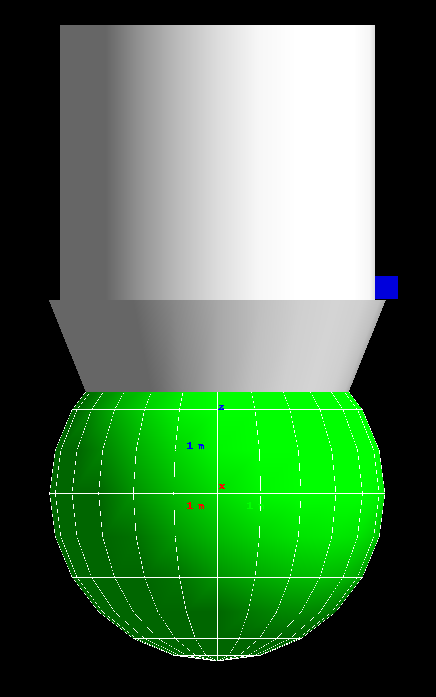


The `.mac` file that was used is provided here for reference:

```shell
# Turn on/off verbosity in various places
/run/verbose 0
/tracking/verbose 0
/control/verbose 1

/nEXO/det/checkOverlap true

# Use Baseline 2023 geometry
/control/execute ./Baseline2023.mac

/EXOPhysicsList/enableLight true

# Kill Gammas below Q value in TPCExternals (energy in keV)
# Set just above the Bi214 2204 keV gamma with 5% intensity
/analysis/setKillGammasBelowThisEnergyInTPCExternals 2205.0

# This is required for all Geant4 simulations.
/run/initialize

# Use Geant4's GPS (general particle source)
/generator/setGenerator gps

# Create an ion with Z=83, A=214 (corresponding to Bi214)
/gps/particle ion
/gps/ion 83 214
/grdm/nucleusLimits 214 214 83 83

# RepeaterBox (note no confining, generates the full box)
/gps/pos/type Volume
/gps/pos/shape Para
/gps/pos/centre 500 2250 2745.8 mm
/gps/pos/halfx 228.6  mm
/gps/pos/halfy 152.4 mm
/gps/pos/halfz 152.4 mm
```

## Data Loading

In [7]:
data_dir = Path("/p/vast1/nexo/data/RepeaterBox/RepeaterBox_Bi214_100B/output/")
plot_dir = Path("/p/vast1/nexo/data/RepeaterBox/RepeaterBox_Bi214_100B/plot/")

branches = [
    "fGenX",
    "fGenY",
    "fGenZ",
    "fTotalEventEnergy",
    "fXpos",
    "fYpos",
    "fZpos",
    "fNESTHitX",
    "fNESTHitY",
    "fNESTHitZ",
    "fNESTHitE",
]

In [9]:
file_list = list(x for x in data_dir.rglob("*.root") if x.is_file())
print(f"Files available: {len(file_list)}")

Files available: 500


In [10]:
%%time
events_orig = ak.to_dataframe(
    up.concatenate(
        {data_dir / "*.root": "Event/Sim/SimEvent"},
        branches,
        allow_missing=True,
        library="ak",
    )
)

CPU times: user 30.9 s, sys: 186 ms, total: 31 s
Wall time: 32.6 s


In [11]:
events = events_orig.copy()
events.index.names = ["event", "hit"]

## Analysis

Since the reconstruction code is undergoind some refactoring and cannot process these simulated data, 
we developed an alternative analysis based on MC-truth information to extract an approximate hit-efficiency.  
This analysis is somewhat inspired by what was used in the [2017 sensitivity paper](https://arxiv.org/abs/1710.05075).

Our data are in a `MultiIndex` `pandas` dataframe. For now we have `events` with `hits`.

See [this documentation page](https://github.com/nEXO-collaboration/nexo-offline/blob/bc383fdd5f78181db6f630436e3c1c90b26ef920/Doc/SimEventDescription.md) 
for the meaning of the variables extracted from the `SimEvent` tree.

In [12]:
events.head()

fGenX        fGenY        fGenZ  fTotalEventEnergy       fXpos  \
event hit                                                                       
0     0    340.18707  2126.880383  2593.842252           0.736366  358.889571   
      1    340.18707  2126.880383  2593.842252           0.736366  249.619094   
      2    340.18707  2126.880383  2593.842252           0.736366 -447.497863   
      3    340.18707  2126.880383  2593.842252           0.736366 -446.452332   
      4    340.18707  2126.880383  2593.842252           0.736366 -446.458886   

                 fYpos        fZpos   fNESTHitX   fNESTHitY   fNESTHitZ  \
event hit                                                                 
0     0    1823.091909  1898.158821 -447.497864 -129.990906 -535.090210   
      1    1373.806095  1388.937989 -446.452332 -130.436005 -534.872070   
      2    -129.990900  -535.090210 -447.582977 -129.989807 -535.180298   
      3    -130.436008  -534.872062 -447.588745 -130.005737 -535.215698   
      4    -130.444075  -534.853530 -447.580048 -130.010818 -535.220764   

            fNESTHitE  
event hit              
0     0      0.677520  
      1     34.556000  
      2    282.331116  
      3    135.444412  
      4     40.996563

### Compute and plot hit-level quantities

In [13]:
events["fRpos"] = np.sqrt(
    events["fXpos"] * events["fXpos"] + events["fYpos"] * events["fYpos"]
)
events["fNESTHitR"] = np.sqrt(
    events["fNESTHitX"] * events["fNESTHitX"]
    + events["fNESTHitY"] * events["fNESTHitY"]
)

Let's check that the particles were correctly generated in the right position

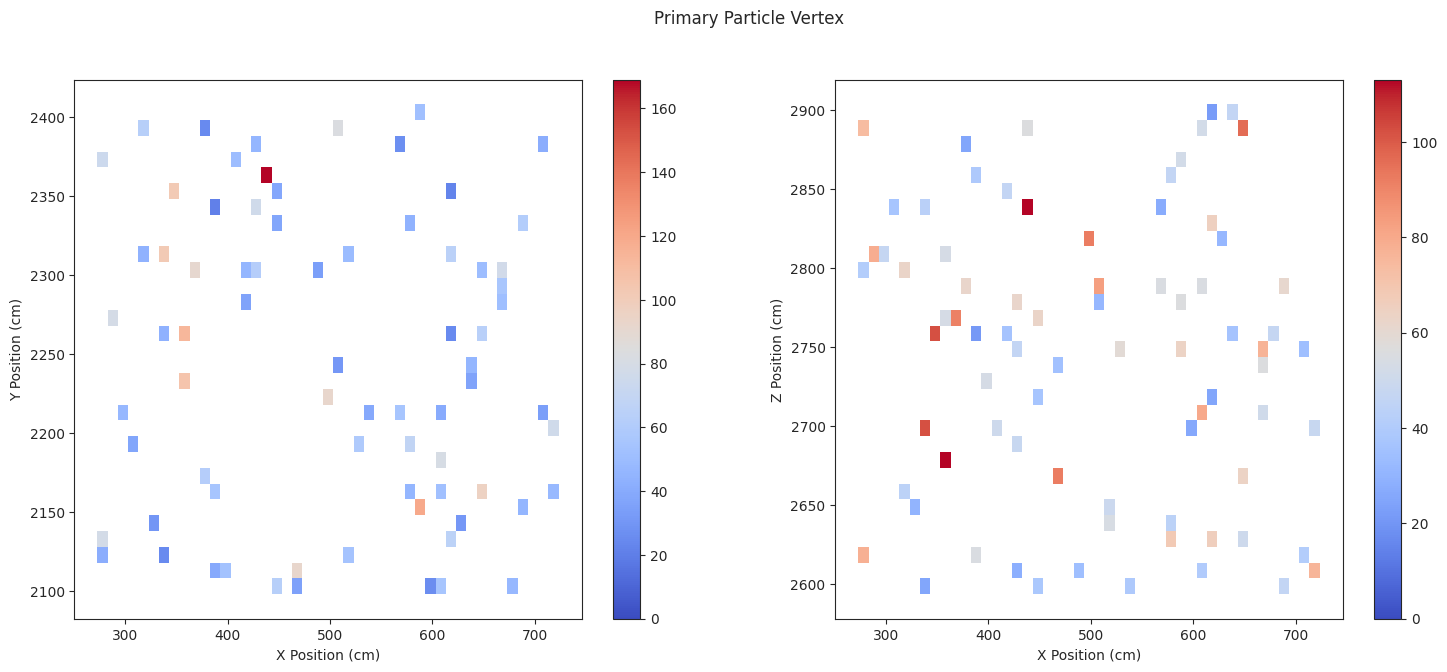

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
plt.suptitle("Primary Particle Vertex")
sns.histplot(
    events,
    x="fGenX",
    y="fGenY",
    binwidth=(10, 10),
    cmap="coolwarm",
    cbar=True,
    ax=ax[0],
)
ax[0].set_xlabel("X Position (cm)")
ax[0].set_ylabel("Y Position (cm)")
sns.histplot(
    events,
    x="fGenX",
    y="fGenZ",
    binwidth=(10, 10),
    cmap="coolwarm",
    cbar=True,
    ax=ax[1],
)
ax[1].set_xlabel("X Position (cm)")
ax[1].set_ylabel("Z Position (cm)")
plt.show()

These are the positions of all energy deposits. Note that energy deposits in the water are saved (if the event has energy deposits in the LXe). 

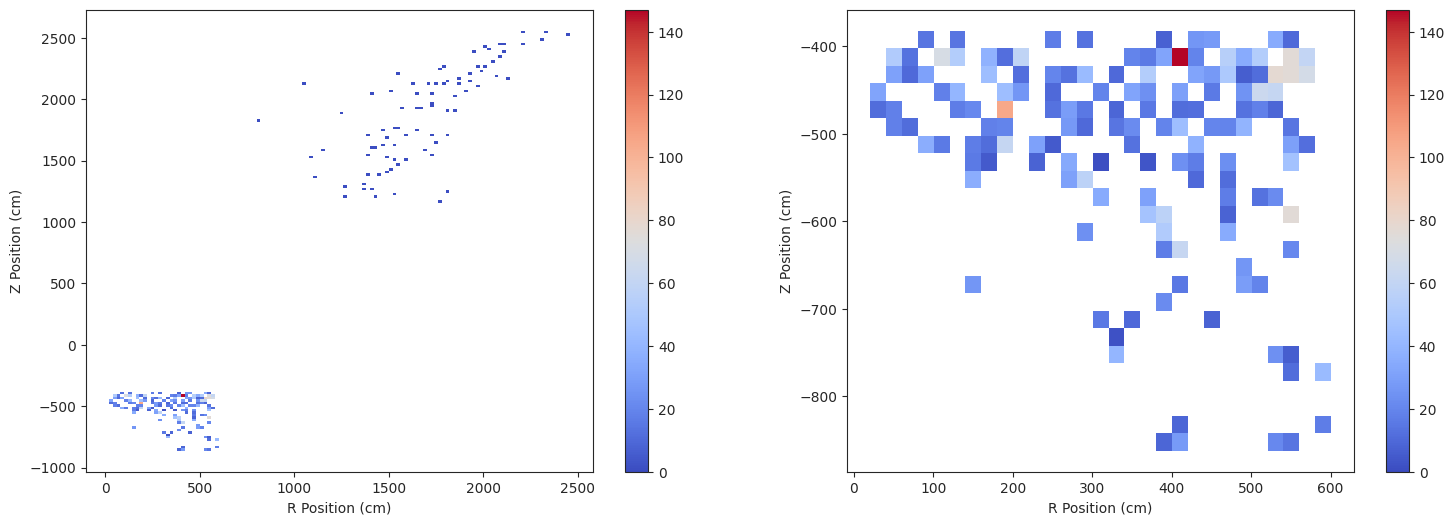

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(
    events,
    x="fRpos",
    y="fZpos",
    binwidth=(20, 20),
    cmap="coolwarm",
    cbar=True,
    ax=ax[0],
)
ax[0].set_xlabel("R Position (cm)")
ax[0].set_ylabel("Z Position (cm)")
sns.histplot(
    events[events["fZpos"] < 0],
    x="fNESTHitR",
    y="fNESTHitZ",
    binwidth=(20, 20),
    cmap="coolwarm",
    cbar=True,
    ax=ax[1],
)
ax[1].set_xlabel("R Position (cm)")
ax[1].set_ylabel("Z Position (cm)")
plt.show()

### Event Visualization

Quick and dirty visualization of the position of all NEST hits

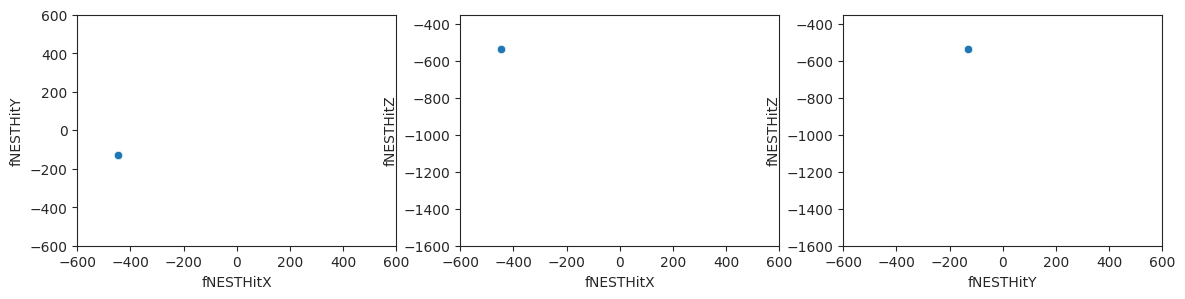

In [17]:
n = 0
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
sns.scatterplot(data=events.loc[n], x="fNESTHitX", y="fNESTHitY", ax=axs[0])
axs[0].set(xlim=(-600, 600), ylim=(-600, 600))
sns.scatterplot(data=events.loc[n], x="fNESTHitX", y="fNESTHitZ", ax=axs[1])
axs[1].set(xlim=(-600, 600), ylim=(-1600, -350))
sns.scatterplot(data=events.loc[n], x="fNESTHitY", y="fNESTHitZ", ax=axs[2])
axs[2].set(xlim=(-600, 600), ylim=(-1600, -350))
plt.show()

### Perform clustering

In [18]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage

Remove all hits outside of the TPC field cage since they are not measurable (at least not by the charge channel)

In [19]:
cathode_z = -1585.97
anode_z = -402.97
fieldrings_r = 566.65
mask = (
    (events.fNESTHitZ > cathode_z)
    & (events.fNESTHitZ < anode_z)
    & (events.fNESTHitR < fieldrings_r)
)
events.drop(events[~mask].index, inplace=True)

For the clustering we use `scipy` hierarchical clustering based on [the nearest point algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). It basically 
cluster all points that are separated by less than a threshold value from their nearest neighbor. 
We have conservatively choosen this value as `max_d`=5 mm. The [2017 sensitivity paper](https://arxiv.org/abs/1710.05075) 
used an algorithm based on a 3 mm radius instead.

In [20]:
def clustering(X, max_d=5):  # max_d in mm
    # See https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

    # X = events.loc[n][['fNESTHitX', 'fNESTHitY', 'fNESTHitZ']]
    # print(X)

    # Nearest Point Algorithm
    Z = linkage(X, method="single", metric="euclidean")
    # print(Z)

    # calculate full dendrogram and visualize it
    # plt.figure(figsize=(30, 10))
    # dendrogram(Z)
    # plt.show()

    clusters = fcluster(Z, max_d, criterion="distance")
    return clusters

In [21]:
clusters = (
    events[["fNESTHitX", "fNESTHitY", "fNESTHitZ"]]
    .groupby(level=0, axis=0, as_index=False)
    .apply(clustering)
)
clusters = clusters.explode().to_frame(name="cluster_id").reset_index()

In [22]:
clustered_events = (
    events.reset_index()
    .merge(clusters[["cluster_id"]], left_index=True, right_index=True)
    .sort_values(["event", "cluster_id", "hit"])
    .set_index(["event", "cluster_id", "hit"])
)

Compute energy-weighted centroids of the clusters

In [23]:
centroids_df = (
    clustered_events[["fNESTHitX", "fNESTHitY", "fNESTHitZ", "fNESTHitE"]]
    .groupby(level=["event", "cluster_id"], axis=0)
    .apply(
        lambda x: np.average(
            x[["fNESTHitX", "fNESTHitY", "fNESTHitZ"]], axis=0, weights=x.fNESTHitE
        )
    )
    .to_frame(name="centroids")
)
# centroids_df.head()

In [24]:
centroids_df[["clusterX", "clusterY", "clusterZ"]] = pd.DataFrame(
    centroids_df.centroids.tolist(), index=centroids_df.index
)
clustered_events = clustered_events.merge(
    centroids_df.drop("centroids", axis=1), left_index=True, right_index=True
)

In [25]:
clustered_events["clusterR"] = np.sqrt(
    clustered_events.clusterX * clustered_events.clusterX
    + clustered_events.clusterY * clustered_events.clusterY
)

Cluster energy is the sum of all the NESTHit in that cluster

In [26]:
clusterE_df = (
    clustered_events[["fNESTHitE"]]
    .groupby(level=["event", "cluster_id"], axis=0)
    .sum()
    .rename(columns={"fNESTHitE": "clusterE"})
)
clustered_events = clustered_events.merge(
    clusterE_df, left_index=True, right_index=True
)

### Cluster Cuts

Delete all clusters with energy less than 35 keV because they are below threshold for detection by the charge channel

In [27]:
clustered_events.drop(
    clustered_events[clustered_events.clusterE < 35].index, inplace=True
)

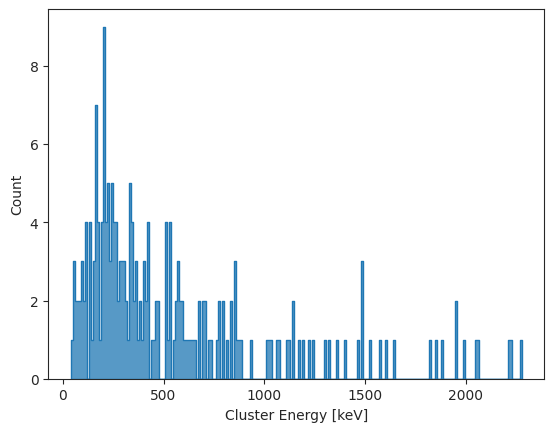

In [28]:
sns.histplot(
    clustered_events.groupby(level=["event", "cluster_id"], axis=0).first(),
    x="clusterE",
    binwidth=10,
    element="step",
)
plt.xlabel("Cluster Energy [keV]")
plt.show()

### Event Energy 

The energy of the event from the sum of the energies of all the clusters within the TPC LXe (active region). 

In theory we could also apply an energy resolution smearing, but because the ROI events are so few, it could systematically
bias the result if not handled well.  It may be better to estimate conservatively the hit efficiency based on a larger ROI.

In [29]:
evTPCEnergy_df = (
    clustered_events[["clusterE"]]
    .groupby(level=["event", "cluster_id"], axis=0)
    .head(1)[["clusterE"]]
    .groupby(level="event")
    .sum()
    .rename(columns={"clusterE": "evTPCEnergy"})
)
clustered_events = clustered_events.merge(
    evTPCEnergy_df, left_index=True, right_index=True
)

### Number of Clusters

In [30]:
nclusters_df = (
    clustered_events.reset_index()
    .groupby(
        [
            "event",
        ],
        axis=0,
    )["cluster_id"]
    .nunique()
    .to_frame(name="nClusters")
)
clustered_events = clustered_events.merge(
    nclusters_df, left_index=True, right_index=True
)

### Standoff

In [31]:
def event_standoff(v):
    # print(v)
    x = v["clusterX"]
    y = v["clusterY"]
    z = v["clusterZ"]
    s_r = 566.65 - (x * x + y * y) ** 0.5
    z_sd = np.minimum(-402.97 - z, z + 1585.97)
    return np.amin(np.minimum(s_r, z_sd))

In [32]:
sd_df = (
    clustered_events[["clusterX", "clusterY", "clusterZ"]]
    .groupby(level=["event", "cluster_id"])
    .head(1)
    .groupby(level="event")
    .apply(event_standoff)
    .to_frame(name="evStandoff")
)
clustered_events = clustered_events.merge(sd_df, left_index=True, right_index=True)

In [33]:
def compute_event_extent(X):
    # print(X)
    dist = pdist(X)
    return max(dist)

In [34]:
extent_res = (
    clustered_events[["fNESTHitX", "fNESTHitY", "fNESTHitZ"]]
    .groupby(level="event", axis=0)
    .apply(compute_event_extent)
)
clustered_events = clustered_events.merge(
    extent_res.to_frame(name="evExtent"), left_index=True, right_index=True
)

Here is the final dataframe

In [35]:
clustered_events

fGenX        fGenY        fGenZ  fTotalEventEnergy  \
event cluster_id hit                                                            
0     1          0    340.187070  2126.880383  2593.842252           0.736366   
                 1    340.187070  2126.880383  2593.842252           0.736366   
                 2    340.187070  2126.880383  2593.842252           0.736366   
                 3    340.187070  2126.880383  2593.842252           0.736366   
                 4    340.187070  2126.880383  2593.842252           0.736366   
...                          ...          ...          ...                ...   
79    1          26   503.635298  2241.969176  2778.568174           1.223580   
                 27   503.635298  2241.969176  2778.568174           1.223580   
                 28   503.635298  2241.969176  2778.568174           1.223580   
                 29   503.635298  2241.969176  2778.568174           1.223580   
                 30   503.635298  2241.969176  2778.568174           1.223580   

                           fXpos        fYpos        fZpos   fNESTHitX  \
event cluster_id hit                                                     
0     1          0    358.889571  1823.091909  1898.158821 -447.497864   
                 1    249.619094  1373.806095  1388.937989 -446.452332   
                 2   -447.497863  -129.990900  -535.090210 -447.582977   
                 3   -446.452332  -130.436008  -534.872062 -447.588745   
                 4   -446.458886  -130.444075  -534.853530 -447.580048   
...                          ...          ...          ...         ...   
79    1          26   220.422960   186.823656  -386.262697   60.966972   
                 27   220.424764   186.824591  -386.260308   60.968594   
                 28   220.424841   186.823068  -386.261452   60.968948   
                 29   220.426197   186.822398  -386.261456   60.969498   
                 30   220.426423   186.821811  -386.261506   60.969650   

                       fNESTHitY   fNESTHitZ  ...   fNESTHitR    clusterX  \
event cluster_id hit                          ...                           
0     1          0   -129.990906 -535.090210  ...  465.995697 -447.272186   
                 1   -130.436005 -534.872070  ...  465.116364 -447.272186   
                 2   -129.989807 -535.180298  ...  466.077087 -447.272186   
                 3   -130.005737 -535.215698  ...  466.087097 -447.272186   
                 4   -130.010818 -535.220764  ...  466.080170 -447.272186   
...                          ...         ...  ...         ...         ...   
79    1          26   147.824020 -503.710724  ...  159.902832   60.946133   
                 27   147.823853 -503.709503  ...  159.903290   60.946133   
                 28   147.822968 -503.710663  ...  159.902603   60.946133   
                 29   147.822739 -503.711578  ...  159.902603   60.946133   
                 30   147.822678 -503.711639  ...  159.902603   60.946133   

                        clusterY    clusterZ    clusterR    clusterE  \
event cluster_id hit                                                   
0     1          0   -130.122986 -535.104919  465.815857  736.365723   
                 1   -130.122986 -535.104919  465.815857  736.365723   
                 2   -130.122986 -535.104919  465.815857  736.365723   
                 3   -130.122986 -535.104919  465.815857  736.365723   
                 4   -130.122986 -535.104919  465.815857  736.365723   
...                          ...         ...         ...         ...   
79    1          26   147.801590 -503.659637  159.874146  698.092590   
                 27   147.801590 -503.659637  159.874146  698.092590   
                 28   147.801590 -503.659637  159.874146  698.092590   
                 29   147.801590 -503.659637  159.874146  698.092590   
                 30   147.801590 -503.659637  159.874146  698.092590   

                      evTPCEnergy  nClusters  evStandoff  evExtent  
ev

## Plots

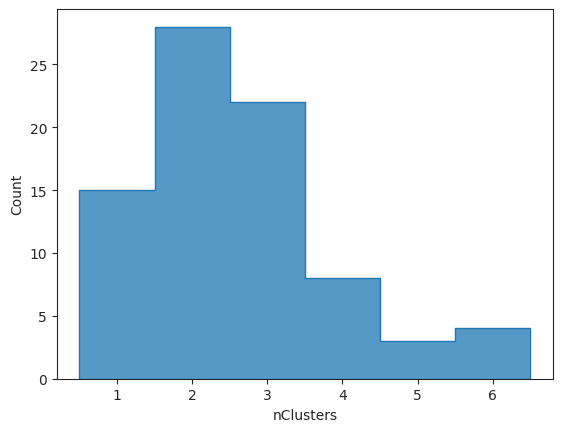

In [36]:
sns.histplot(
    clustered_events.groupby(
        level=[
            "event",
        ],
        axis=0,
    ).head(1),
    x="nClusters",
    binwidth=1,
    discrete=True,
    element="step",
)
plt.show()

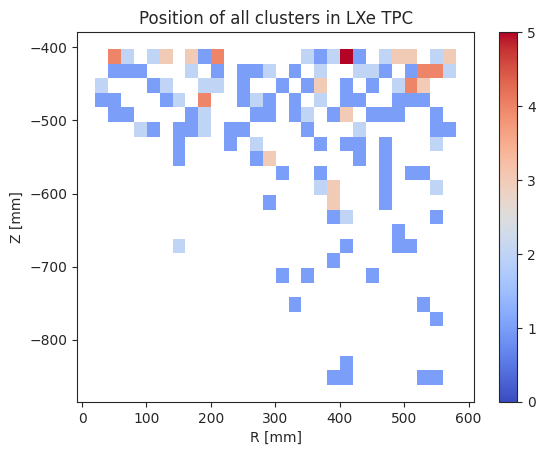

In [37]:
sns.histplot(
    clustered_events.groupby(level=["event", "cluster_id"], axis=0).head(1),
    x="clusterR",
    y="clusterZ",
    binwidth=(20, 20),
    cmap="coolwarm",
    cbar=True,
)
plt.title("Position of all clusters in LXe TPC")
plt.xlabel("R [mm]")
plt.ylabel("Z [mm]")
plt.show()

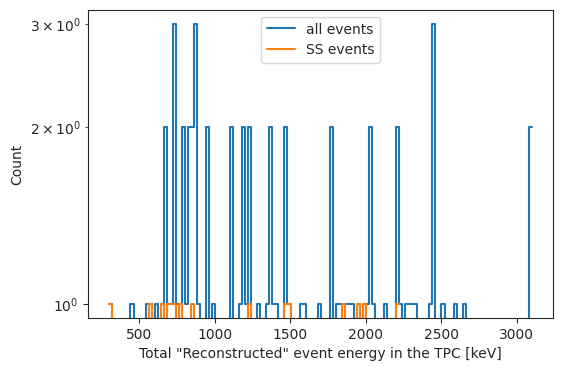

In [38]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(
    clustered_events.groupby(
        level=[
            "event",
        ],
        axis=0,
    ).head(1),
    x="evTPCEnergy",
    binwidth=20,
    ax=ax,
    label="all events",
    element="step",
    fill=False,
)
sns.histplot(
    clustered_events[clustered_events["nClusters"] == 1]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1),
    x="evTPCEnergy",
    binwidth=20,
    ax=ax,
    label="SS events",
    element="step",
    fill=False,
)
plt.xlabel('Total "Reconstructed" event energy in the TPC [keV]')
plt.legend()
plt.semilogy()
plt.show()

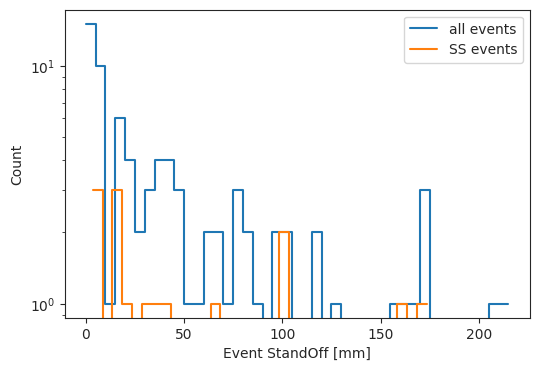

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(
    clustered_events.groupby(
        level=[
            "event",
        ],
        axis=0,
    ).head(1),
    x="evStandoff",
    binwidth=5,
    ax=ax,
    label="all events",
    element="step",
    fill=False,
)
sns.histplot(
    clustered_events[clustered_events["nClusters"] == 1]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1),
    x="evStandoff",
    binwidth=5,
    ax=ax,
    label="SS events",
    element="step",
    fill=False,
)
plt.xlabel("Event StandOff [mm]")
plt.semilogy()
plt.legend()
plt.show()

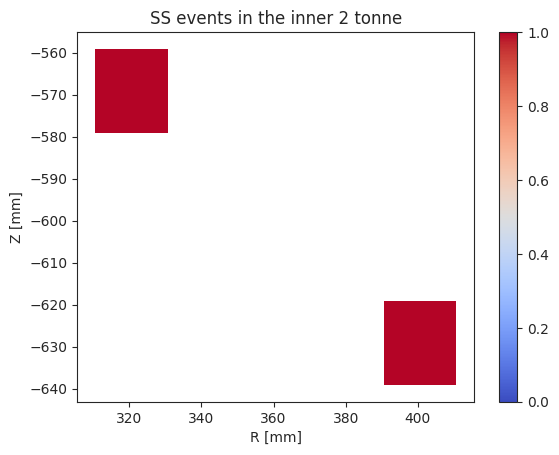

In [40]:
sns.histplot(
    clustered_events[
        (clustered_events["nClusters"] == 1) & (clustered_events["evStandoff"] > 102)
    ]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1),
    x="clusterR",
    y="clusterZ",
    binwidth=(20, 20),
    cmap="coolwarm",
    cbar=True,
)
plt.title("SS events in the inner 2 tonne")
plt.xlabel("R [mm]")
plt.ylabel("Z [mm]")
plt.show()

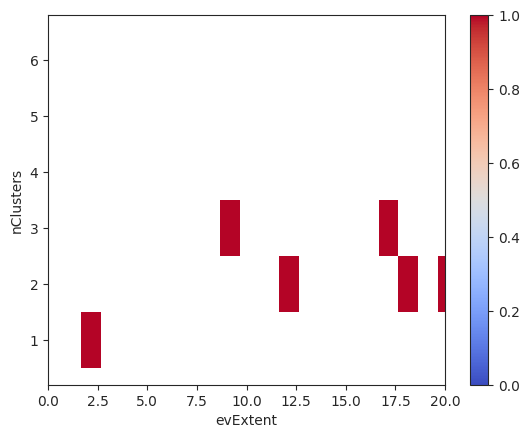

In [51]:
sns.histplot(
    clustered_events[(clustered_events.evTPCEnergy > 2000)]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1),
    x="evExtent",
    y="nClusters",
    binwidth=(1, 1),
    cmap="coolwarm",
    cbar=True,
    discrete=(False, True),
)
plt.xlim(0, 20)
plt.show()

## Results

There are no events in the inner 2 ton above 2.3 MeV, 
hence we can only set an upper limit on the hit efficiency at 90% CL as: 
$$
\epsilon < (2.3) \times 10^{-11}
$$

Once the reconstruction algorithms in `nexo-offline` have been updated, this result should be compared against that
analysis.

In [55]:
tmp = (
    clustered_events[
        (clustered_events.nClusters == 1)
        & (clustered_events.evStandoff > 102)
        & (clustered_events.evTPCEnergy > 2300)
    ]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1)[["evTPCEnergy", "evExtent", "evStandoff"]]
)
tmp.sort_values(by="evTPCEnergy", ascending=False)

,,,evTPCEnergy,evExtent,evStandoff
event,cluster_id,hit,,,


For reference, the total number of SS+MS events in the inner 2 ton and depositing > 2.3 MeV is only 3. 

In [56]:
tmp = (
    clustered_events[
        (clustered_events.nClusters >= 1)
        & (clustered_events.evStandoff > 102)
        & (clustered_events.evTPCEnergy > 2300)
    ]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1)[
        [
            "nClusters",
            "evTPCEnergy",
            "evExtent",
            "evStandoff",
        ]
    ]
    .sort_values(by="evTPCEnergy", ascending=False)
)
len(tmp)
tmp

,,,nClusters,evTPCEnergy,evExtent,evStandoff
event,cluster_id,hit,,,,
21,1,0,3,2447.687012,147.898501,206.252838
36,1,1,3,2447.285156,8.831328,173.430054
11,2,7,4,2333.079834,79.322772,164.412811
